# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from bookdata.db import db_url

## Load Link Stats

The `integration_stats` table in the database contains link success statistics in our data.

In [3]:
link_stats = pd.read_sql_table('integration_stats', db_url())
link_stats.head()

,dataset,gender,n_books,n_actions
0,LOC-MDS,no-loc-author,842755,NaN
1,LOC-MDS,female,664221,NaN
2,LOC-MDS,unknown,1214597,NaN
3,LOC-MDS,ambiguous,53232,NaN
4,LOC-MDS,male,2195117,NaN


Let's create lists for our different codes, in order, for later handling.  We'll start with the resolved codes:

In [4]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [5]:
unlink_codes = ['no-viaf-author', 'no-loc-author', 'no-book']

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot(index='dataset', columns='gender', values='n_books')
book_counts = book_counts.reindex(columns=link_codes + unlink_codes)
book_counts

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,215556,480628,17056,236219,157072,1161611,NaN
BX-E,38093,55906,4014,16900,7627,29130,NaN
BX-I,67087,96933,6770,34614,15631,58466,NaN
GR-E,174996,276045,11087,95887,35267,487495,NaN
GR-I,176640,279442,11189,97667,36106,495592,NaN
LOC-MDS,664221,2195117,53232,1214597,297405,842755,NaN


In [7]:
act_counts = link_stats.pivot(index='dataset', columns='gender', values='n_actions')
act_counts = act_counts.reindex(columns=link_codes + unlink_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,4313858.0,6557232.0,535239.0,2069787.0,810625.0,8173794.0,NaN
BX-E,138827.0,185054.0,30444.0,27434.0,9763.0,35761.0,NaN
BX-I,391728.0,467603.0,76294.0,77892.0,26277.0,90020.0,NaN
GR-E,32348714.0,33638049.0,8346632.0,3598667.0,599206.0,8006298.0,NaN
GR-I,71070367.0,68540386.0,13491116.0,9640560.0,1720205.0,24480644.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1: continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,0.095036,0.211904,0.007520,0.104146,0.069251,0.512142,NaN
BX-E,0.251157,0.368603,0.026465,0.111426,0.050287,0.192062,NaN
BX-I,0.240024,0.346807,0.024222,0.123842,0.055925,0.209180,NaN
GR-E,0.161917,0.255413,0.010258,0.088720,0.032631,0.451060,NaN
GR-I,0.161074,0.254817,0.010203,0.089061,0.032924,0.451920,NaN
LOC-MDS,0.126102,0.416742,0.010106,0.230591,0.056462,0.159997,NaN


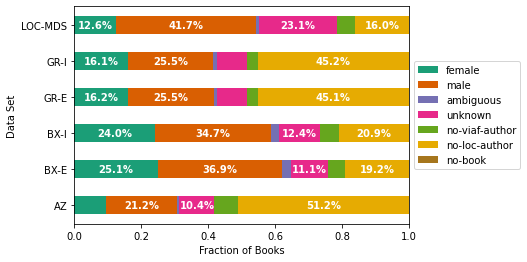

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.095036,0.211904,0.007520,0.104146,0.581393
BX-E,0.251157,0.368603,0.026465,0.111426,0.242349
BX-I,0.240024,0.346807,0.024222,0.123842,0.265105
GR-E,0.161917,0.255413,0.010258,0.088720,0.483691
GR-I,0.161074,0.254817,0.010203,0.089061,0.484845
LOC-MDS,0.126102,0.416742,0.010106,0.230591,0.216459


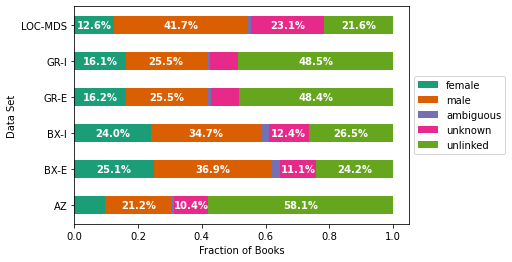

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

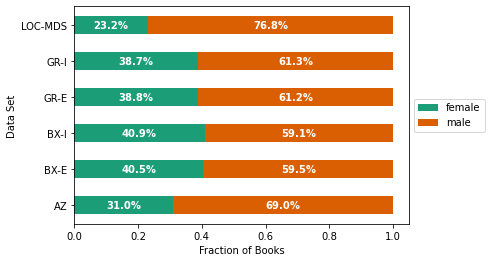

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-viaf-author,no-loc-author,no-book
dataset,,,,,,,
AZ,0.192064,0.291945,0.023830,0.092152,0.036091,0.363918,NaN
BX-E,0.324906,0.433095,0.071250,0.064206,0.022849,0.083694,NaN
BX-I,0.346719,0.413876,0.067528,0.068942,0.023258,0.079677,NaN
GR-E,0.373811,0.388710,0.096451,0.041585,0.006924,0.092518,NaN
GR-I,0.376147,0.362756,0.071403,0.051024,0.009104,0.129566,NaN


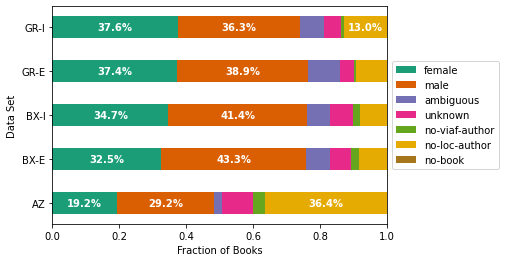

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.192064,0.291945,0.023830,0.092152,0.400009
BX-E,0.324906,0.433095,0.071250,0.064206,0.106543
BX-I,0.346719,0.413876,0.067528,0.068942,0.102935
GR-E,0.373811,0.388710,0.096451,0.041585,0.099442
GR-I,0.376147,0.362756,0.071403,0.051024,0.138670


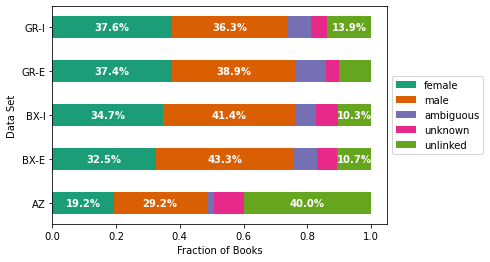

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

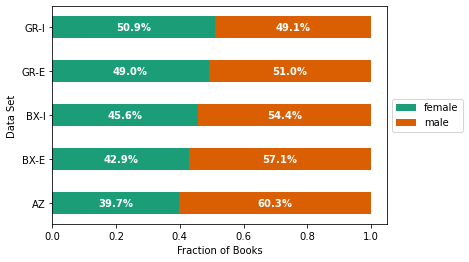

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.314460
BX-E       0.646225
BX-I       0.611053
GR-E       0.427589
GR-I       0.426095
LOC-MDS    0.552950
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')